In [18]:
import torch
import torchvision
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
import numpy as np


In [19]:
data_transfrom = transforms.Compose([  # 对读取的图片进行以下指定操作
    transforms.ToTensor(),             # 向量化,向量化时 每个点的像素值会除以255,整个向量中的元素值都在0-1之间      
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    transforms.Resize((300, 300)),# 图片放缩为 (300, 300), 统一处理的图像最好设置为统一的大小,这样之后的处理也更加方便
])

batch_size = 4

# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

torch.manual_seed(42)

num_epochs = 10

k = 5

splits=KFold(n_splits=k,shuffle=True,random_state=42)

foldperf={}

# classes = ('AMD', 'CSR', 'DR', 'MH', 'NORMAL')
# trainset = datasets.ImageFolder('./OCT_segmented/processed/train', transform=data_transfrom)  # 指明读取的文件夹和读取方式,注意指明的是到文件夹的路径,不是到图片的路径
# testset = datasets.ImageFolder('./OCT_segmented/processed/val', transform=data_transfrom)  # 指明读取的文件夹和读取方式,注意指明的是到文件夹的路径,不是到图片的路径

classes = ('CSR', 'DR', 'MH', 'NORMAL')
trainset = datasets.ImageFolder('./OCT_data/train', transform=data_transfrom)
testset = datasets.ImageFolder('./OCT_data/test', transform=data_transfrom)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=1)  # 指定读取配置信息
# testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=True, num_workers=1)


In [20]:
print(trainset)

Dataset ImageFolder
    Number of datapoints: 322
    Root location: ./OCT_data/train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
               Resize(size=(300, 300), interpolation=bilinear, max_size=None, antialias=None)
           )


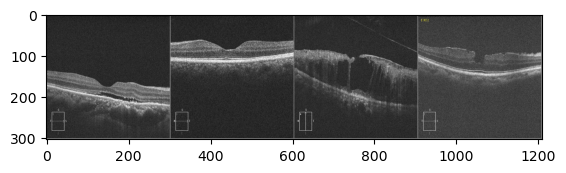

CSR   NORMAL DR    MH   


tensor([0, 3, 1, 2])

In [26]:
# functions to show an image

def imshow(img):
    img = img / 2 + 0.5              # unnormalize for not segmented
#     img = (img - img.min()) * 10     # unnormalize for segmented
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))

# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))
labels

In [5]:

def train_epoch(model,dataloader,loss_fn,optimizer):
    train_loss,train_correct=0.0,0
    model.train()
    for images, labels in dataloader:

#         images,labels = images.to(device),labels.to(device)
        optimizer.zero_grad()
        output = model(images)
        loss = loss_fn(output,labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * images.size(0)
        scores, predictions = torch.max(output.data, 1)
        train_correct += (predictions == labels).sum().item()

    return train_loss,train_correct
  
def valid_epoch(model,dataloader,loss_fn):
    valid_loss, val_correct = 0.0, 0
    model.eval()
    for images, labels in dataloader:

#         images,labels = images.to(device),labels.to(device)
        output = model(images)
        loss=loss_fn(output,labels)
        valid_loss+=loss.item()*images.size(0)
        scores, predictions = torch.max(output.data,1)
        val_correct+=(predictions == labels).sum().item()

    return valid_loss,val_correct

In [6]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(82944, 120)
#         self.fc1 = nn.Linear(122000, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()

In [7]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [8]:
# Training

# # No cross vidation
# for epoch in range(num_epochs):  # loop over the dataset multiple times

#     running_loss = 0.0
#     for i, data in enumerate(trainloader, 0):
#         # get the inputs; data is a list of [inputs, labels]
#         inputs, labels = data

#         # zero the parameter gradients
#         optimizer.zero_grad()

#         # forward + backward + optimize
#         outputs = net(inputs)
#         loss = criterion(outputs, labels)
#         loss.backward()
#         optimizer.step()

#         # print statistics
#         running_loss += loss.item()
#         if i % 10 == 9:    # print every 10 mini-batches
#             print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 10:.3f}')
#             running_loss = 0.0
            
# Cross validation

history = {'train_loss': [], 'test_loss': [],'train_acc':[],'test_acc':[]}

for fold, (train_idx,val_idx) in enumerate(splits.split(np.arange(len(trainset)))):

    print('Fold {}'.format(fold + 1))

    train_sampler = torch.utils.data.SubsetRandomSampler(train_idx)
    test_sampler = torch.utils.data.SubsetRandomSampler(val_idx)
    train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, sampler=train_sampler)
    test_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, sampler=test_sampler)
    
#     model = ConvNet()
#     model.to(device)
    optimizer.zero_grad()

    for epoch in range(num_epochs):
        train_loss, train_correct=train_epoch(net,train_loader,criterion,optimizer)
        test_loss, test_correct=valid_epoch(net,test_loader,criterion)

        train_loss = train_loss / len(train_loader.sampler)
        train_acc = train_correct / len(train_loader.sampler) * 100
        test_loss = test_loss / len(test_loader.sampler)
        test_acc = test_correct / len(test_loader.sampler) * 100

        print("Epoch:{}/{} AVG Training Loss:{:.3f} AVG Test Loss:{:.3f} AVG Training Acc {:.2f} % AVG Test Acc {:.2f} %".format(epoch + 1,
                                                                                                             num_epochs,
                                                                                                             train_loss,
                                                                                                             test_loss,
                                                                                                             train_acc,
                                                                                                             test_acc))
        history['train_loss'].append(train_loss)
        history['test_loss'].append(test_loss)
        history['train_acc'].append(train_acc)
        history['test_acc'].append(test_acc)   

print('Finished Training')

Fold 1
Epoch:1/10 AVG Training Loss:1.834 AVG Test Loss:1.530 AVG Training Acc 20.23 % AVG Test Acc 23.08 %
Epoch:2/10 AVG Training Loss:1.493 AVG Test Loss:1.487 AVG Training Acc 29.96 % AVG Test Acc 27.69 %
Epoch:3/10 AVG Training Loss:1.450 AVG Test Loss:1.421 AVG Training Acc 28.40 % AVG Test Acc 33.85 %
Epoch:4/10 AVG Training Loss:1.310 AVG Test Loss:1.419 AVG Training Acc 37.35 % AVG Test Acc 35.38 %
Epoch:5/10 AVG Training Loss:1.250 AVG Test Loss:1.260 AVG Training Acc 42.80 % AVG Test Acc 38.46 %
Epoch:6/10 AVG Training Loss:1.139 AVG Test Loss:1.241 AVG Training Acc 46.69 % AVG Test Acc 35.38 %
Epoch:7/10 AVG Training Loss:1.130 AVG Test Loss:1.213 AVG Training Acc 43.19 % AVG Test Acc 35.38 %
Epoch:8/10 AVG Training Loss:1.034 AVG Test Loss:1.002 AVG Training Acc 47.08 % AVG Test Acc 46.15 %
Epoch:9/10 AVG Training Loss:1.014 AVG Test Loss:0.995 AVG Training Acc 47.86 % AVG Test Acc 41.54 %
Epoch:10/10 AVG Training Loss:1.360 AVG Test Loss:1.241 AVG Training Acc 33.85 % AVG

In [9]:
# # Save net model
# PATH = './oct_net.pth'
# torch.save(net.state_dict(), PATH)

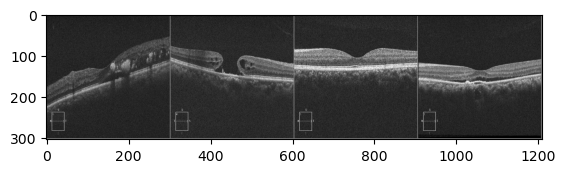

GroundTruth:  DR    MH    NORMAL CSR  


In [27]:
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=True, num_workers=1)
dataiter = iter(testloader)
images, labels = next(dataiter)

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))

In [11]:
# # Load net model
# net = Net()
# net.load_state_dict(torch.load(PATH))

In [12]:
outputs = net(images)

In [13]:
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join(f'{classes[predicted[j]]:5s}'
                              for j in range(4)))

Predicted:  NORMAL DR    CSR   DR   


In [14]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        images, labels = data
        # calculate outputs by running images through the network
        outputs = net(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

Accuracy of the network on the 10000 test images: 66 %


In [15]:
# prepare to count predictions for each class08
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# again no gradients needed
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

Accuracy for class: CSR   is 33.3 %
Accuracy for class: DR    is 74.1 %
Accuracy for class: MH    is 47.6 %
Accuracy for class: NORMAL is 87.0 %


In [16]:
# device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# # Assuming that we are on a CUDA machine, this should print a CUDA device:

# print(device)